In [68]:
# Importando as bibliotecas necessárias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
import sklearn
import imblearn

# Configurando o tamanho das figuras
plt.rcParams['figure.figsize'] = (16, 5)
# Configurando o estilo da plotagem
plt.style.use('fivethirtyeight')

# Ignorar notificações
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## Leitura do DataSet

In [71]:
# Carregando os datasets
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

In [72]:
# Exibindo as 5 primeiras linhas do nosso dataset de treino
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [73]:
# Verificando o tamanho(shape) do dataset
print("O tamanho do dataset de treino é:", train.shape)
print("O tamanho do dataset de teste é:", test.shape)

O tamanho do dataset de treino é: (54808, 14)
O tamanho do dataset de teste é: (23490, 13)


In [74]:
# Verificando as colunas no dataset de treino
train.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'is_promoted'],
      dtype='object')

In [75]:
# Verificando as colunas no dataset de teste
test.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score'],
      dtype='object')

In [76]:
# Contanto os dados por Departmentos
train['department'].value_counts()

Sales & Marketing    16840
Operations           11348
Procurement           7138
Technology            7138
Analytics             5352
Finance               2536
HR                    2418
Legal                 1039
R&D                    999
Name: department, dtype: int64

In [77]:
# Contando os dados por Região
train['region'].value_counts()

region_2     12343
region_22     6428
region_7      4843
region_15     2808
region_13     2648
region_26     2260
region_31     1935
region_4      1703
region_27     1659
region_16     1465
region_28     1318
region_11     1315
region_23     1175
region_29      994
region_32      945
region_19      874
region_20      850
region_14      827
region_25      819
region_17      796
region_5       766
region_6       690
region_30      657
region_8       655
region_10      648
region_1       610
region_24      508
region_12      500
region_9       420
region_21      411
region_3       346
region_34      292
region_33      269
region_18       31
Name: region, dtype: int64

## Estatística Descritiva

In [78]:
# Variáveis contínuas
train.describe().style.background_gradient(cmap = 'copper')

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


In [79]:
# Variáveis Categóricas
train.describe(include='object')

,department,region,education,gender,recruitment_channel
count,54808,54808,52399,54808,54808
unique,9,34,3,2,3
top,Sales & Marketing,region_2,Bachelor's,m,other
freq,16840,12343,36669,38496,30446


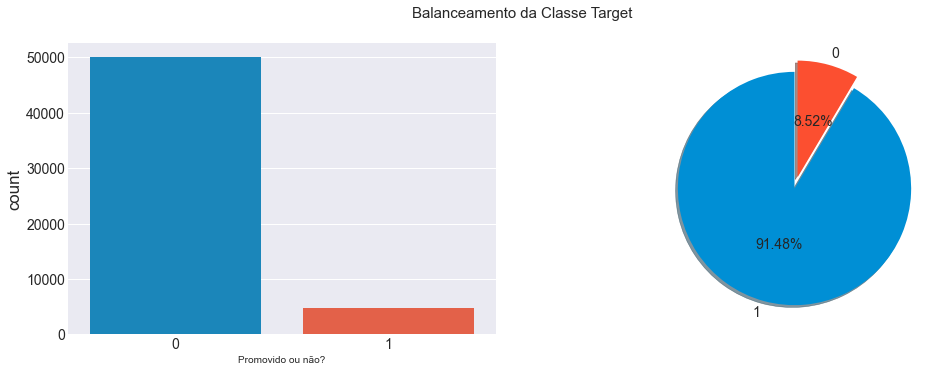

In [80]:
# Verificando o balanceamento da classe Target

plt.rcParams['figure.figsize'] = (15, 5)
plt.style.use('seaborn-darkgrid')

plt.subplot(1, 2, 1)
sns.countplot(train['is_promoted'],)

plt.xlabel('Promovido ou não?', fontsize = 10)

plt.subplot(1, 2, 2)
train['is_promoted'].value_counts().plot(kind = 'pie', explode = [0, 0.1], autopct = '%.2f%%', startangle = 90,
                                       labels = ['1','0'], shadow = True, pctdistance = 0.5)
plt.axis('off')

plt.suptitle('Balanceamento da Classe Target', fontsize = 15)
plt.show()

É possível verificar que a classe Target está bastante desbalanceada, é necessario balancea-la. A maioria das vezes quando usamos modelos de Machine Learning com classes desbalanceadas, nós temos resultados bem ruins que são completamente enviesados por conta de classes com alta distribuição.

## Valores faltantes (Missing Values)

In [81]:
# Missing Values no dataset de treinamento

# Total de missing values no dataset de treinamento
train_total = train.isnull().sum()

# Percentual de missing values no dataset
train_percent = ((train.isnull().sum()/train.shape[0])*100).round(2)

# Total de missing values no dataset de teste
test_total = test.isnull().sum()

# Percentual de missing values no dataset
test_percent = ((test.isnull().sum()/test.shape[0])*100).round(2)

# Concatenando o percentual do missing values em um novo dataframe
train_missing_data = pd.concat([train_total, train_percent, test_total, test_percent],
                                axis=1, 
                                keys=['Train_Total', 'Train_Percent %','Test_Total', 'Test_Percent %'],
                                sort = True)
# Visualizando os dados para destacar as variáveis com os valores faltantes(missing values) 
train_missing_data.style.bar(color = ['salmon'])

,Train_Total,Train_Percent %,Test_Total,Test_Percent %
KPIs_met >80%,0,0.000000,0.000000,0.000000
age,0,0.000000,0.000000,0.000000
avg_training_score,0,0.000000,0.000000,0.000000
awards_won?,0,0.000000,0.000000,0.000000
department,0,0.000000,0.000000,0.000000
education,2409,4.400000,1034.000000,4.400000
employee_id,0,0.000000,0.000000,0.000000
gender,0,0.000000,0.000000,0.000000
is_promoted,0,0.000000,nan,nan
length_of_service,0,0.000000,0.000000,0.000000


Na tabela acima, somente duas colunas tem missing values nos datasets de treino e teste. O percentual de missing values é de 4% e 7% em "education" e "previous_year_rating" respectivamente. Então não é ideal deletar os missing values, ao invés disso, podemos inserir os valores usando média(mean), mediana(median) e moda(mode).

In [82]:
# Inserindo o valor da moda(mode) nas colunas com missing values no dataset de treino

train['education'] = train['education'].fillna(train['education'].mode()[0])
train['previous_year_rating'] = train['previous_year_rating'].fillna(train['previous_year_rating'].mode()[0])

# Vamos verificar se ainda existem valores faltantes
print("Número de missing values no dataset de treino :", train.isnull().sum().sum())

Número de missing values no dataset de treino : 0


In [83]:
# Inserindo o valor da moda(mode) nas colunas com missing values no dataset de teste

test['education'] = test['education'].fillna(test['education'].mode()[0])
test['previous_year_rating'] = test['previous_year_rating'].fillna(test['previous_year_rating'].mode()[0])

# Vamos verificar se ainda existem valores faltantes
print("Número de missing values no dataset de teste :", test.isnull().sum().sum())

Número de missing values no dataset de teste : 0


## Detecção de Outliers
A presença de outliers em um modelo de classificação ou regressão pode resultar em um fraco fit e baixa performance em modelos preditivos de machine learning. Métodos automáticos de detecção de outliers podem ser usados em modelagens de pipeline e podem ser comparados como outras transformações que devem ser aplicadas em um dataset.

In [84]:
# Analisando as colunas do tipo "number"
train.select_dtypes('number').head()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,1,35,5.0,8,1,0,49,0
1,65141,1,30,5.0,4,0,0,60,0
2,7513,1,34,3.0,7,0,0,50,0
3,2542,2,39,1.0,10,0,0,50,0
4,48945,1,45,3.0,2,0,0,73,0


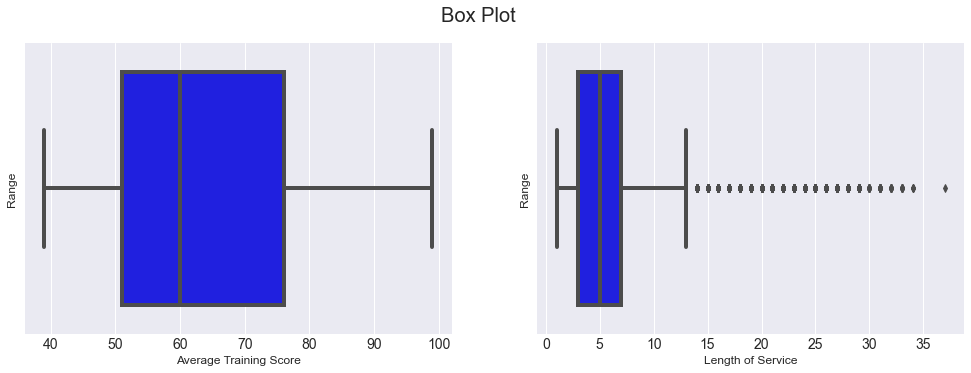

In [18]:
# Usando o boxplot para verificar algumas colunas que temos suspeita de outliers
plt.rcParams['figure.figsize'] = (15, 5)
plt.style.use('seaborn-darkgrid')

# Boxplot para a coluna avg_training_score
plt.subplot(1, 2, 1)
sns.boxplot(train['avg_training_score'], color = 'blue')
plt.xlabel('Average Training Score', fontsize = 12)
plt.ylabel('Range', fontsize = 12)

# Boxplot para coluns length_of_service
plt.subplot(1, 2, 2)
sns.boxplot(train['length_of_service'], color = 'blue')
plt.xlabel('Length of Service', fontsize = 12)
plt.ylabel('Range', fontsize = 12)

plt.suptitle('Box Plot', fontsize = 20)
plt.show()

In [85]:
# Removendo os outliers da coluna "Length of Service", manteremos aqueles com o tempo de serviço de até 13 anos
train = train[train['length_of_service'] < 14]
test = test[test['length_of_service'] < 14]

## Analise Univariada

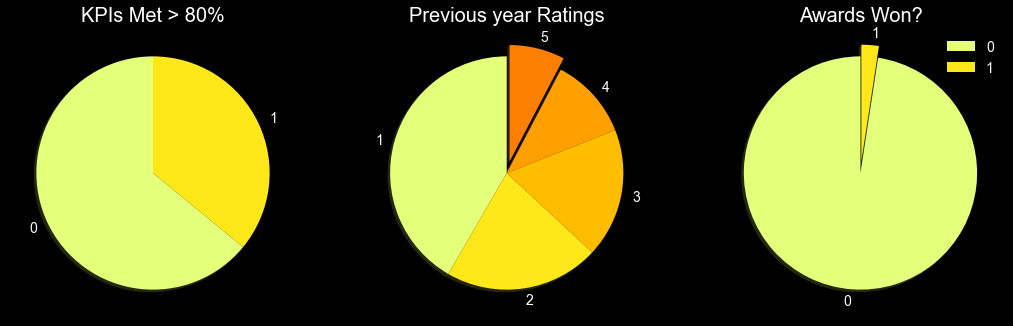

In [86]:
# Plotando gráficos de pizza 
plt.rcParams['figure.figsize'] = (16,5)
plt.style.use('dark_background')

# Plotando um gráfico de pizza para representar a coluna dos KPIs alcançados
plt.subplot(1, 3, 1)
labels = ['0','1']
sizes = train['KPIs_met >80%'].value_counts()
colors = plt.cm.Wistia(np.linspace(0, 1, 5))
explode = [0, 0]

plt.pie(sizes, labels = labels, colors = colors, explode = explode, shadow = True, startangle = 90)
plt.title('KPIs Met > 80%', fontsize = 20)

# Plotando um gráfico de pizza para representar as avaliação de performance do ano anterior dos funcionários
plt.subplot(1, 3, 2)
labels = ['1', '2', '3', '4', '5']
sizes = train['previous_year_rating'].value_counts()
colors = plt.cm.Wistia(np.linspace(0, 1, 5))
explode = [0, 0, 0, 0, 0.1]

plt.pie(sizes, labels = labels, colors = colors, explode = explode, shadow = True, startangle = 90)
plt.title('Previous year Ratings', fontsize = 20)

# Plotando um gráfico de pizza para representar os funcionários que receberam premiação
plt.subplot(1, 3, 3)
labels = ['0', '1']
sizes = train['awards_won?'].value_counts()
colors = plt.cm.Wistia(np.linspace(0, 1, 5))
explode = [0,0.1]

plt.pie(sizes, labels = labels, colors = colors, explode = explode, shadow = True, startangle = 90)
plt.title('Awards Won?', fontsize = 20)


plt.legend()
plt.show()

Analisando o pie chart nós podemos tirar algumas lições:

1 - Menos da metade dos funcionários conseguiram alcançar pelo menos 80% de suas metas

2 - Uma parcela pequena dos funcionários conseguiu uma avaliação de performance boa no ano anterior

3 - Poucos funcionários, algo em torno de 2% receberam alguma premiação por seus serviços. o que não é tão estranho

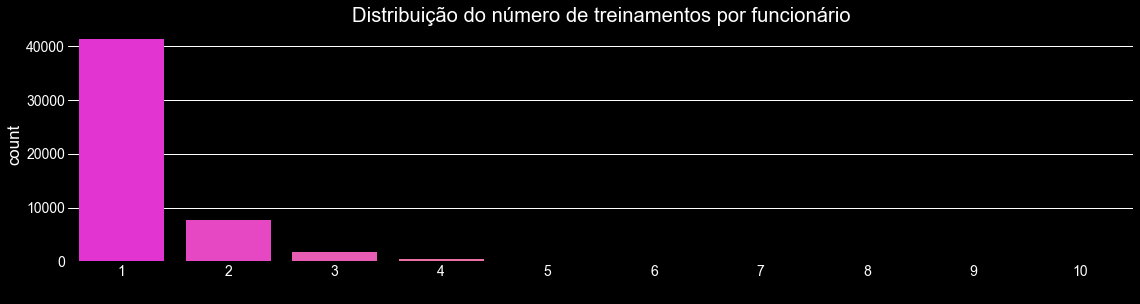

In [87]:
# Verificando a distribuição dos treinamentos realizados pelos funcionários

plt.rcParams['figure.figsize'] = (17,4)
sns.countplot(train['no_of_trainings'], palette = 'spring')
plt.xlabel(' ', fontsize = 14)
plt.title('Distribuição do número de treinamentos por funcionário')
plt.show()

É possível observar no gráfico acima que a grande maioria dos funcionários realizou apenas um treinamento, e uma minoria realizou 3 ou 4 treianemtos.

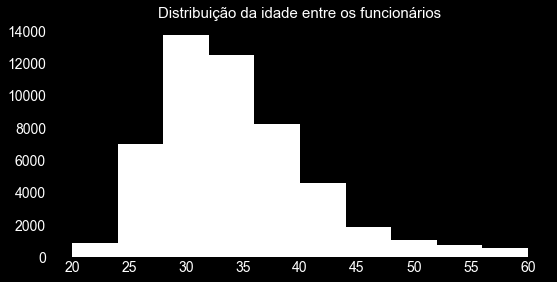

In [88]:
# Verificando a idade dos funcionários

plt.rcParams['figure.figsize'] = (8,4)
plt.hist(train['age'], color = 'white')
plt.title('Distribuição da idade entre os funcionários', fontsize = 15)
plt.grid()
plt.show()

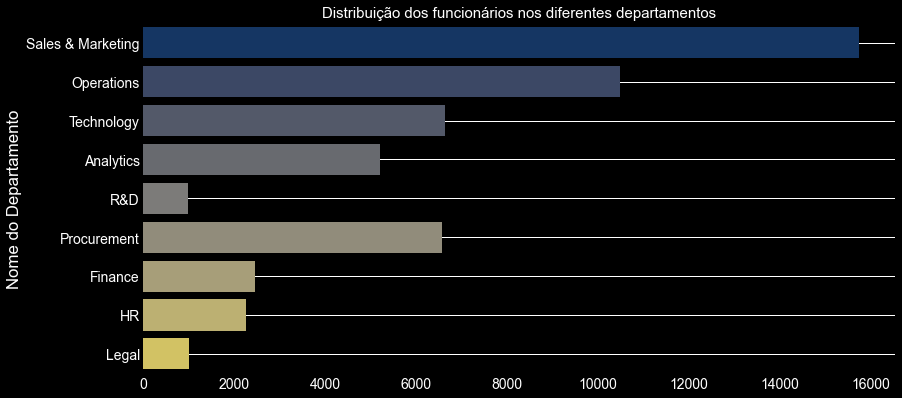

In [89]:
# Verificando os departamentos

plt.rcParams['figure.figsize'] = (12,6)
sns.countplot(y = train['department'], palette = 'cividis', orient = 'v')
plt.xlabel('')
plt.ylabel('Nome do Departamento')
plt.title('Distribuição dos funcionários nos diferentes departamentos', fontsize = 15)
plt.grid()
plt.show()

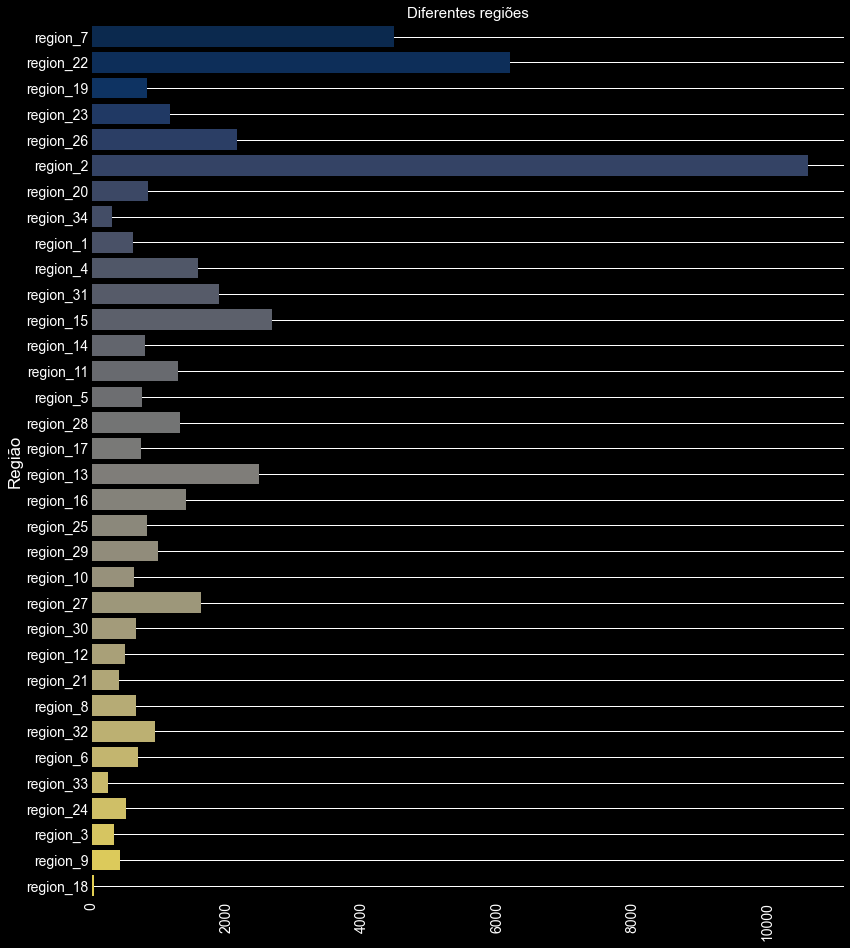

In [90]:
# Verificando as diferentes regiões

plt.rcParams['figure.figsize'] = (12,15)
plt.style.use('seaborn-muted')
sns.countplot(y = train['region'], palette = 'cividis', orient = 'v')
plt.xlabel('')
plt.ylabel('Região')
plt.title('Diferentes regiões', fontsize = 15)
plt.xticks(rotation = 90)
plt.grid()
plt.show()

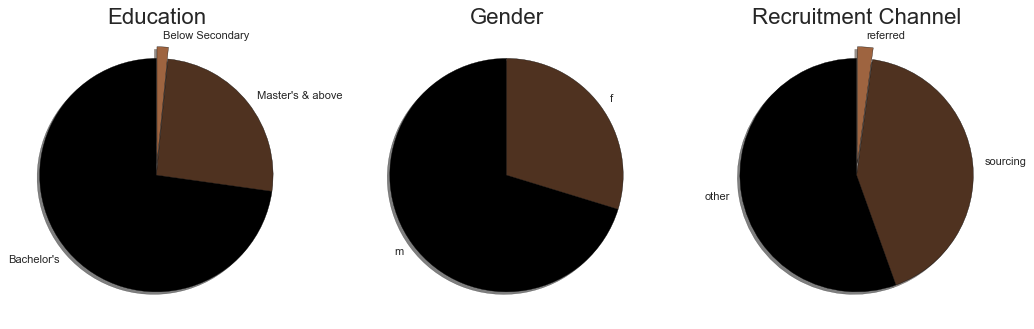

In [94]:
# Plotando outros gráficos de pizza para representar as colunas
plt.rcParams['figure.figsize'] = (16,5)
plt.style.use('tableau-colorblind10')

# Plotando um gráfico de pizza para representar o nível de formação escolar
plt.subplot(1, 3, 1)
labels = train['education'].value_counts().index
sizes = train['education'].value_counts()
colors = plt.cm.copper(np.linspace(0, 1, 5))
explode = [0, 0, 0.1]

plt.pie(sizes, labels = labels, colors = colors, explode = explode, shadow = True, startangle = 90)
plt.title('Education', fontsize = 20)

# Plotando um gráfico de pizza para representar a gênero
plt.subplot(1, 3, 2)
labels = train['gender'].value_counts().index
sizes = train['gender'].value_counts()
colors = plt.cm.copper(np.linspace(0, 1, 5))
explode = [0, 0]

plt.pie(sizes, labels = labels, colors = colors, explode = explode, shadow = True, startangle = 90)
plt.title('Gender', fontsize = 20)

# Plotando um gráfico de pizza para representar o canal de recrutamento do funcionário
plt.subplot(1, 3, 3)
labels = train['recruitment_channel'].value_counts().index
sizes = train['recruitment_channel'].value_counts()
colors = plt.cm.copper(np.linspace(0, 1, 5))
explode = [0, 0, 0.1]

plt.pie(sizes, labels = labels, colors = colors, explode = explode, shadow = True, startangle = 90)
plt.title('Recruitment Channel', fontsize = 20)
plt.show()

## Análise Bivariada

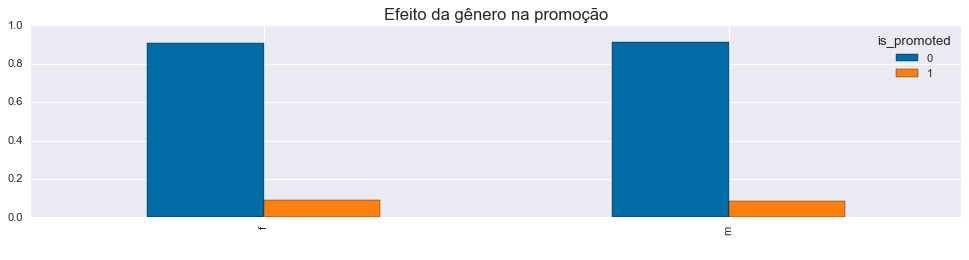

In [95]:
# Verificando se existe alguma diferença na promoção por gênero

plt.rcParams['figure.figsize'] = (15, 3)
x = pd.crosstab(train['gender'], train['is_promoted'])
x.div(x.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = False)
plt.title('Efeito da gênero na promoção', fontsize = 15)
plt.xlabel(' ')
plt.show()

Aqui podemos observar que não existe um efeito significante do gênero para promoção, mais a frente deletaremos essa feature do dataset

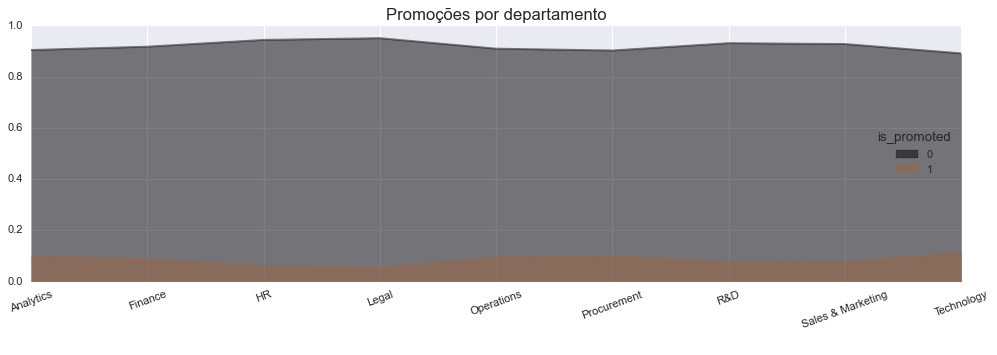

In [101]:
# Comparando o efeito dos diferentes departamentos na promoção
plt.rcParams['figure.figsize'] = (15,4)
plt.style.use('seaborn-muted')

x = pd.crosstab(train['department'], train['is_promoted'])
colors = plt.cm.copper(np.linspace(0, 1, 3))
x.div(x.sum(1).astype(float), axis = 0).plot(kind = 'area', stacked = False, color = colors)
plt.title('Promoções por departamento', fontsize = 15)
plt.xticks(rotation = 20)
plt.xlabel(' ')
plt.show()

O gráfico acima mostra que o departamento não exerce muita influência sobre os critérios de promoção

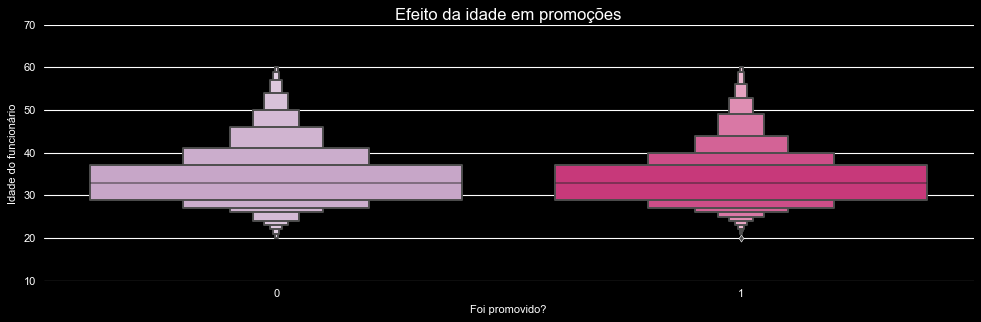

In [106]:
# Efeito da idade na promoção

plt.rcParams['figure.figsize'] = (15,4)
plt.style.use('dark_background')
sns.boxenplot(train['is_promoted'], train['age'], palette = 'PuRd')
plt.title('Efeito da idade em promoções', fontsize = 15)
plt.xlabel('Foi promovido?', fontsize = 10)
plt.ylabel('Idade do funcionário', fontsize = 10)
plt.show()

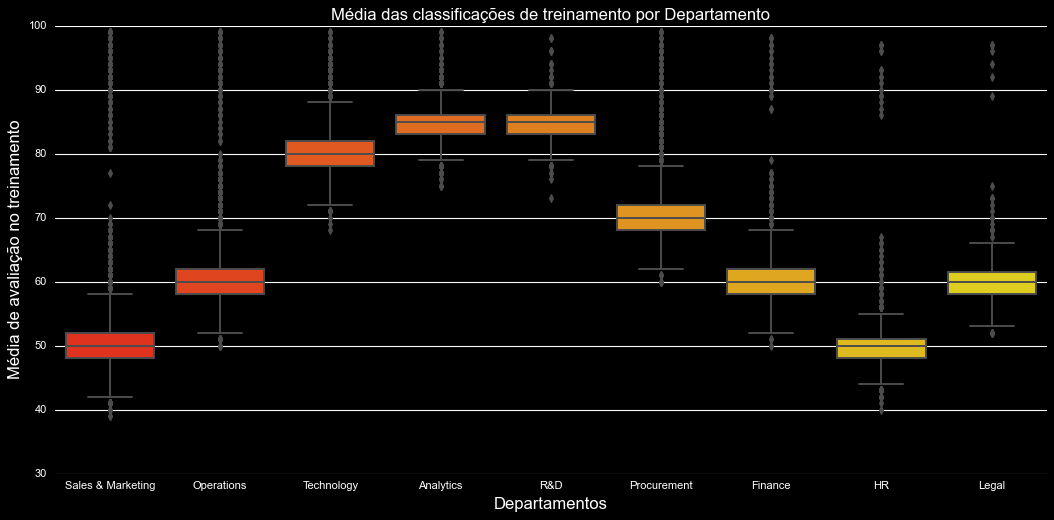

In [107]:
# Department Vs Average Training Score

plt.rcParams['figure.figsize'] = (16, 7)
sns.boxplot(train['department'], train['avg_training_score'], palette = 'autumn')
plt.title('Média das classificações de treinamento por Departamento', fontsize = 15)
plt.ylabel('Média de avaliação no treinamento', fontsize = 15)
plt.xlabel('Departamentos', fontsize = 15)
plt.show()

## Análise Multivariada

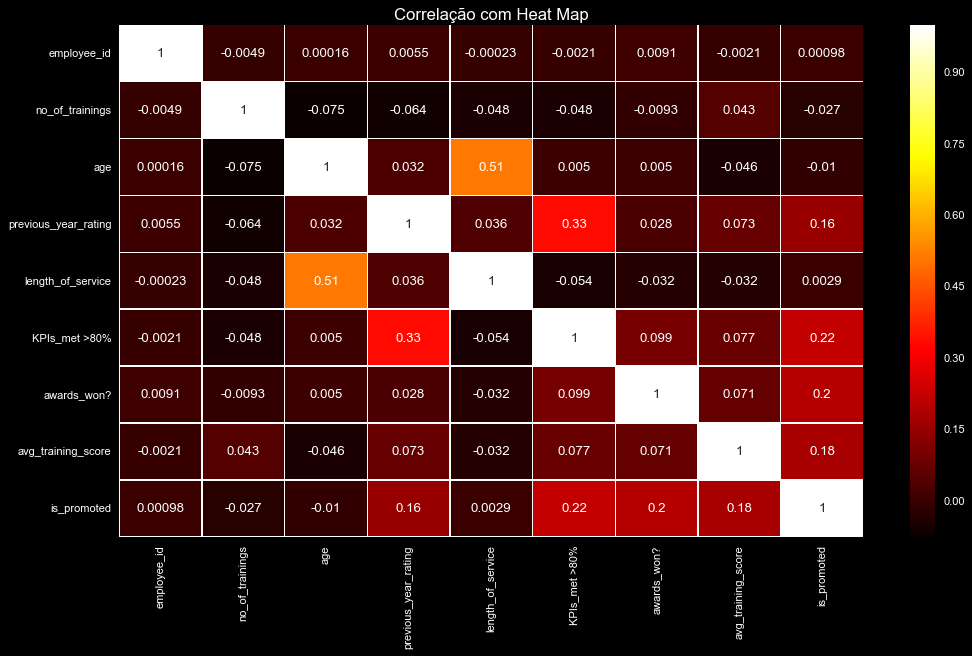

In [108]:
# Usando o Heatmap para representar os dados com as suas respectivas correlações

plt.rcParams['figure.figsize'] = (15,8)
sns.heatmap(train.corr(), annot = True, linewidth = 0.5, cmap = 'hot')
plt.title('Correlação com Heat Map', fontsize = 15)
plt.show()

É possível visualizar algumas correlações como:

Length of Service x Age (0.49)

KPIs x Previos year rate (0.40)

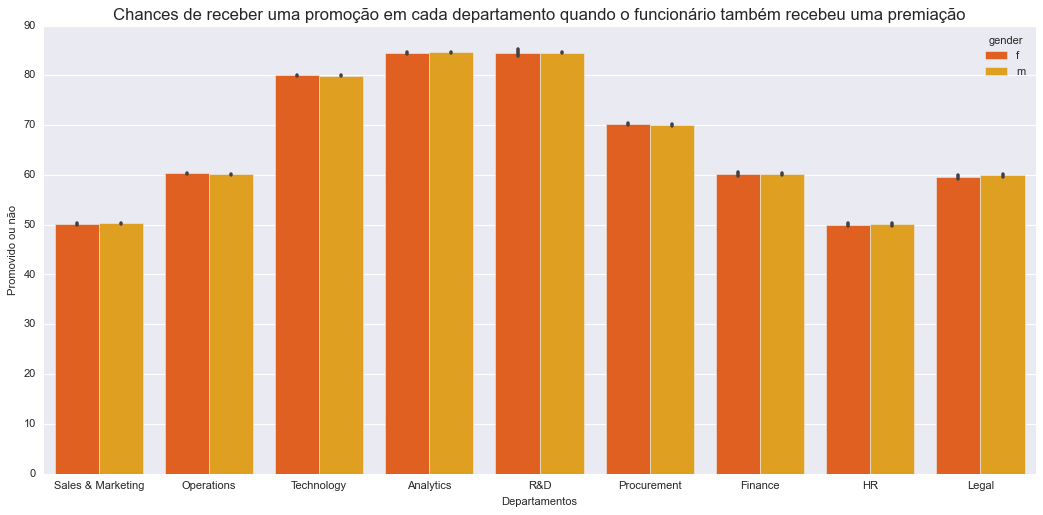

In [113]:
# Verificando a relação de Departamentos e Promoções quando os funcionários são premiados

plt.rcParams['figure.figsize'] = (16,7)
plt.style.use('seaborn-darkgrid')
sns.barplot(train['department'], train['avg_training_score'], hue = train['gender'], palette = 'autumn')
plt.title('Chances de receber uma promoção em cada departamento quando o funcionário também recebeu uma premiação', fontsize = 15)
plt.ylabel('Promovido ou não', fontsize = 10)
plt.xlabel('Departamentos', fontsize = 10)
plt.show()

## Feature Engineering

In [114]:
# Criando features extra baseada em features existentes para melhorar o modelo

# Criando uma metrica de soma
train['sum_metric'] = train['awards_won?']+train['KPIs_met >80%'] + train['previous_year_rating']
test['sum_metric'] = test['awards_won?']+test['KPIs_met >80%'] + test['previous_year_rating']

# Criando uma coluna para score total
train['total_score'] = train['avg_training_score'] * train['no_of_trainings']
test['total_score'] = test['avg_training_score'] * test['no_of_trainings']

In [115]:
# Removendo algumas columas que são se mostraram muito importantes durante a análise

# Algumas coisas que já sabemos a respeito do dataset:
# A coluna recruitment channel é pouco relacionada com a promoção dos funcionários, então iremos remove-la
# Da mesma forma a coluna region não mostrou ser muito efetiva para uma promoção, também iremos remove-la
# Também removeremos a coluna employee id
# Por fim também removeremos a coluna gender que mostrou que apesar de o número de mulheres ser menor, isso não mostrou impacto
# sobre o critério de promoção

train = train.drop(['recruitment_channel', 'region', 'employee_id', 'gender'], axis = 1)
test = test.drop(['recruitment_channel', 'region', 'employee_id', 'gender'], axis = 1)

# Verificando as colunas após a deleção das features
train.columns

Index(['department', 'education', 'no_of_trainings', 'age',
       'previous_year_rating', 'length_of_service', 'KPIs_met >80%',
       'awards_won?', 'avg_training_score', 'is_promoted', 'sum_metric',
       'total_score'],
      dtype='object')

In [116]:
'''
Vamos verificar os número de funcionários que não receberam premiação, não alcançaram o KPI 80+, o previous_year_rating foi 1,
média da avaliação de treinamento menor que 60, mas mesmo assim foi promovido
''' 
train[(train['KPIs_met >80%'] == 0) & (train['previous_year_rating'] == 1.0) & 
      (train['awards_won?'] == 0) & (train['avg_training_score'] < 60) & (train['is_promoted'] == 1)]

,department,education,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,sum_metric,total_score
31860,Sales & Marketing,Bachelor's,1,27,1.0,2,0,0,58,1,1.0,58
51374,Sales & Marketing,Bachelor's,1,31,1.0,5,0,0,58,1,1.0,58


In [117]:
# Vamos remover as 2 linhas acima porque elas tem um efeito negativo em nossos dados de treino

# Vamos verificar o tamanho dos dados de treino antes deletar
print("Antes de deletar as 2 linhas :", train.shape)

train = train.drop(train[(train['KPIs_met >80%'] == 0) & (train['previous_year_rating'] == 1.0) & 
      (train['awards_won?'] == 0) & (train['avg_training_score'] < 60) & (train['is_promoted'] == 1)].index)

# Vamos verificar o tamanho dos dados de treino depois de deletar
print("Depois de deletar as 2 linhas :", train.shape)

Antes de deletar as 2 linhas : (51319, 12)
Depois de deletar as 2 linhas : (51317, 12)


## Trabalhando com variáveis Categóricas

In [118]:
# Verificando as colunas categóricas do dataset
train.select_dtypes('object').head()

,department,education
0,Sales & Marketing,Master's & above
1,Operations,Bachelor's
2,Sales & Marketing,Bachelor's
3,Sales & Marketing,Bachelor's
4,Technology,Bachelor's


In [119]:
# Verificando a quantidade de dados na coluna education
train['education'].value_counts()

Bachelor's          37346
Master's & above    13166
Below Secondary       805
Name: education, dtype: int64

In [120]:
# Faremos o encode da coluna education através do seu grau de importância
train['education'] = train['education'].replace(("Master's & above", "Bachelor's", "Below Secondary"),
                                               (3, 2, 1))
test['education'] = test['education'].replace(("Master's & above", "Bachelor's", "Below Secondary"),
                                               (3, 2, 1))
# Usando o Label Encoding para Departamento(Department) e converter-lo em numérico
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['department'] = le.fit_transform(train['department'])
test['department'] = le.fit_transform(test['department'])

#Verificando se ainda temos alguma variável categórica após o encoding
print(train.select_dtypes('object').columns)
print(test.select_dtypes('object').columns)

Index([], dtype='object')
Index([], dtype='object')


In [121]:
#Verificando os dados após o encoding
train.head(5)

,department,education,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,sum_metric,total_score
0,7,3,1,35,5.0,8,1,0,49,0,6.0,49
1,4,2,1,30,5.0,4,0,0,60,0,5.0,60
2,7,2,1,34,3.0,7,0,0,50,0,3.0,50
3,7,2,2,39,1.0,10,0,0,50,0,1.0,100
4,8,2,1,45,3.0,2,0,0,73,0,3.0,73


## Separando os dados (Splitting the Data)
Este processo é muito importante, pois precisamos separa a variável resposta das variáveis independentes
* Vamos renomear a variável resposta como y
* O resto das variáveis será x, deletando a variável resposta y do dataset
* Também mudaremos o nome do dataset de teste para x_test

In [122]:
# Separando a variável resposta da dataset train
y = train['is_promoted']
# Criando a variável x com as variáveis independentes
x = train.drop(['is_promoted'], axis = 1)
# Renomenado o dataset de test para x_test
x_test = test

# Imprimindo o tamanho desses novos dastaset
print("Shape of the x :", x.shape)
print("Shape of the y :", y.shape)
print("Shape of the x Test :", x_test.shape)

Shape of the x : (51317, 11)
Shape of the y : (51317,)
Shape of the x Test : (22005, 11)


## Reamostragem (Resampling)
Reamostragem é o método que consiste em extrair amostras repetidas das amostras de dados originais. O método de reamostragem é um método não paramétrico de inferência estatística
Estamos aplicando esse processo porque a variável resposta está muito desbalanceada, quando trás muito mais dados de funcionários não promovidos do que promovidos, tendo em vista que isso causará avaliações muitos ruins no modelo 

In [124]:
# É muito importante reamostrar os dados, a variável reposta está muito desbalanceada.
# Vamos usar a técnica Over Sampling para reamostrar os dados
# Vamos importar o algorítimo SMOTe para fazer isso

from imblearn.over_sampling import SMOTE
x_resample, y_resample = SMOTE().fit_resample(x, y.values.ravel())

# Vamos imprimir o tamanho de x e y depois da reamostragem
print(x_resample.shape)
print(y_resample.shape)

(93770, 11)
(93770,)


In [125]:
# Contando os valores da variável resposta

print("Antes da reamostragem(resampling) :")
print(y.value_counts())

print("Depois da reamostragem(resampling) :")
y_resample = pd.DataFrame(y_resample)
print(y_resample[0].value_counts())

Antes da reamostragem(resampling) :
0    46885
1     4432
Name: is_promoted, dtype: int64
Depois da reamostragem(resampling) :
0    46885
1    46885
Name: 0, dtype: int64


In [126]:
# Vamos criar um dataset de validação a partir dos dados de treino, então poderemos verificar se o modelo que criamos é bom.
# Vamos importar a livraria train_test_split do sklearn to fazer isso.

from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_resample, y_resample, test_size = 0.2, random_state = 0)

#Agora podemos imprimir os tamanhos novamente
print("Tamanho de x train: ", x_train.shape)
print("Tamanho de y train: ", y_train.shape)
print("Tamanho de x valid: ", x_valid.shape)
print("Tamanho de y valid: ", y_valid.shape)
print("Tamanho de x Test:" , x_test.shape)

Tamanho de x train:  (75016, 11)
Tamanho de y train:  (75016, 1)
Tamanho de x valid:  (18754, 11)
Tamanho de y valid:  (18754, 1)
Tamanho de x Test: (22005, 11)


##  Machine Learning para prever os resultados

#### Random Forest Classifier
É um método de classificação ou regressão que funciona por meio da construção de várias de árvores de decisão durante o treinamento

In [140]:
# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(x_train, y_train.values.ravel())

y_pred = model.predict(x_valid)

Acurácia do treino:  0.9846965980590807
Acurácia do teste:  0.9422523195051722


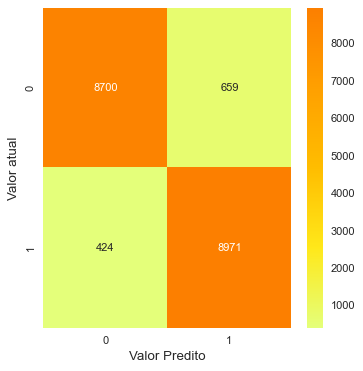

In [141]:
from sklearn.metrics import confusion_matrix, classification_report
print("Acurácia do treino: ", model.score(x_train, y_train))
print("Acurácia do teste: ", model.score(x_valid, y_valid))

cm = confusion_matrix(y_valid, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, cmap = 'Wistia', fmt = '.8g')
plt.xlabel('Valor Predito')
plt.ylabel('Valor atual')
plt.show()

In [142]:
# Relatório de Classificação
cr = classification_report(y_valid, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      9359
           1       0.93      0.95      0.94      9395

    accuracy                           0.94     18754
   macro avg       0.94      0.94      0.94     18754
weighted avg       0.94      0.94      0.94     18754



In [145]:
# Salvando
# Pickle do modelo para usar no app, este modelo já treinado será usado para realizar as previsões
import pickle
pickle.dump(model, open('employee_promotion_prediction.pkl', 'wb'))

Ao final escolheremos o algorítimo RandomForestClassifier pois foi que obteve os melhores resultados

In [146]:
test.head()

,department,education,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,sum_metric,total_score
0,8,2,1,24,3.0,1,1,0,77,4.0,77
1,2,2,1,31,3.0,5,0,0,51,3.0,51
2,7,2,1,31,1.0,4,0,0,47,1.0,47
3,5,2,3,31,2.0,9,0,0,65,2.0,195
4,1,2,1,30,4.0,7,0,0,61,4.0,61
